In [106]:
import re
import jieba
import cntext as ct
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from bertopic import BERTopic

umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0, metric='cosine')
# hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=1,metric='euclidean', cluster_selection_method='eom')
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom')

stopwords = ct.load_pkl_dict('STOPWORDS.pkl')['STOPWORDS']['chinese']

def clean_text(text):
    words = jieba.lcut(text)
    words = [w for w in words if w not in stopwords]
    return ' '.join(words)



In [3]:
from gensim.models import KeyedVectors

chinese_news_models = KeyedVectors.load_word2vec_format('sgns.merge.word.bz2', unicode_errors='ignore')



In [107]:

topic_model = BERTopic(language="chinese (simplified)", 
                       embedding_model=chinese_news_models,
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model,
                       calculate_probabilities=False, 
                       verbose=True,
                       nr_topics='auto'
                       )

In [108]:
import pandas as pd
data = pd.read_csv('./weibo_data.csv',encoding='gbk')
data.head()
weibo_content_list=data.iloc[:, 11].tolist()
weibo_fenlei_list=data.iloc[:,4].tolist()
weibo_hot_list=data.iloc[:,5].tolist()


In [109]:
data['date']=pd.to_datetime(data['date'])

In [110]:
#print(data['date'])
data_sorted = data.sort_values(by='date')


In [111]:
data_sorted.reset_index(inplace=True)


In [112]:
weibo_content_list=data_sorted.iloc[:, 12].tolist()
weibo_fenlei_list=data_sorted.iloc[:,5].tolist()
weibo_hot_list=data_sorted.iloc[:,6].tolist()
weibo_tuple_list = []
for i in range(len(weibo_hot_list)):
    hot_num=int(weibo_hot_list[i]/500000)
    if(hot_num==0):hot_num=1
    weibo_tuple_list.append((weibo_content_list[i],hot_num))



In [113]:
result_groups=[]
data_sorted['date']=pd.to_datetime(data_sorted['date'])
interval = pd.Timedelta(days=3)
start_time=data_sorted.iloc[0]['date']
start_index=data_sorted.index[0]
for index,row in data_sorted.iterrows():
    if row['date'] - start_time >= interval:
        result_groups.append(list(range(start_index,index)))
        start_time=row['date']
        start_index=index
result_groups.append(list(range(start_index,len(data_sorted))))
print(result_groups)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

In [115]:
topic_set=['政治 军事 经济 科技','综艺 电视剧 电影','运动 游戏 比赛','生活 健康 情感 家庭',]
hot_data=[]

In [116]:
print(len(result_groups))

122


In [117]:
id=0
hot_data=[]
hot_content_data=[]
hot_represent_data=[]

for time_part in result_groups:
    hot_data_part=[]
    hot_data_content_part=[]
    hot_present_data_part=[]
    data_weibo_div=weibo_tuple_list[time_part[0]:time_part[-1]]
    data_final=[]
    for i in data_weibo_div:
        #data_final.append((clean_text(i[0]),i[1]))
        if(len(i[0])>=3):
            data_final.append((clean_text(i[0]),i[1]))
    data_times_final=[]
    for i in data_final:
        for j in range(i[1]):
            data_times_final.append(i[0])
    #print(len(data_times_final))
    docs = data_times_final
    topics, probs = topic_model.fit_transform(docs)
    topic_info=topic_model.get_topic_info()
    topic_index=topic_info.iloc[:,0].tolist()
    topic_cnt=topic_info.iloc[:,1].tolist()
    if(topic_index[0]!=-1):
        print('Here?')
        continue
        new_topics = topic_model.reduce_outliers(docs, topics)
        topic_model.update_topics(docs, topics=new_topics)
    topic_info=topic_model.get_topic_info()
    topic_cnt=topic_info.iloc[:,1].tolist()
    topic_content=topic_info.iloc[:,2].tolist()
    topic_represent=topic_info.iloc[:,3].tolist()
    for my_topic in topic_set:
        hot_my_topic = 0  
        hot_content_slice=[]
        hot_represent_slice=[]
        if(len(topic_cnt)<=10):
            similar_topics, similarity = topic_model.find_topics(my_topic, top_n=1)
        elif(len(topic_cnt)<=20):
            similar_topics, similarity = topic_model.find_topics(my_topic, top_n=1)
        else:
            similar_topics, similarity = topic_model.find_topics(my_topic, top_n=2)
        for similar_topic in similar_topics:
            # hot_my_topic+=topic_cnt[similar_topic+1]*similarity[similar_topics.index(similar_topic)]
            # hot_content_slice=topic_content[similar_topic+1]
            # hot_represent_slice=topic_represent[similar_topic+1]
            if(similar_topic == -1):
                continue
            else:
                if(similarity[similar_topics.index(similar_topic)]>=0.5):
                    hot_content_slice.append(topic_content[similar_topic+1])
                    hot_represent_slice.append(topic_represent[similar_topic+1])
                    hot_my_topic+=topic_cnt[similar_topic+1]*similarity[similar_topics.index(similar_topic)]
        hot_data_part.append(hot_my_topic)
        hot_data_content_part.append(hot_content_slice)
        hot_present_data_part.append(hot_represent_slice)
        

    hot_data.append(hot_data_part)
    hot_content_data.append(hot_data_content_part)
    hot_represent_data.append(hot_present_data_part)
    # flg = topic_model.visualize_documents(docs)
    # flg.write_image(f'img/{id}.png')
    id+=1


    

2023-12-25 03:30:45,925 - BERTopic - Embedding - Transforming documents to embeddings.
100%|██████████| 998/998 [00:00<00:00, 5681.88it/s]
2023-12-25 03:30:46,367 - BERTopic - Embedding - Completed ✓
2023-12-25 03:30:46,367 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2023-12-25 03:30:49,915 - BERTopic - Dimensionality - Completed ✓
2023-12-25 03:30:49,916 - BERTopic - Cluster - Start clustering the reduced embeddings
2023-12-25 03:30:49,939 - BERTopic - Cluster - Completed ✓
2023-12-25 03:30:49,941 - BERTopic - Representation - Extracting topics from clusters using representation models.
2023-12-25 03:30:49,977 - BERTopic - Representation - Completed ✓
2023-12-25 03:30:49,978 - BERTopic - Topic reduction - Reducing number of topics
2023-12-25 03:30:50,011 - BERTopic - Topic reduction - Reduced number of topics from 13 to 13
2023-12-25 03:30:50,311 - BERTopic - Embedding - Transforming documents to embeddings.
100%|██████████| 1211/1211 [00:00<00:00, 141

In [118]:
hot_data_trans=[]
for i in range(len(hot_data[0])):
    hot_this_topic=[]
    for j in hot_data:
        hot_this_topic.append(j[i])
    hot_data_trans.append(hot_this_topic)

hot_content_data_trans=[]
for i in range(len(hot_content_data[0])):
    hot_this_topic=[]
    for j in hot_content_data:
        hot_this_topic.append(j[i])
    hot_content_data_trans.append(hot_this_topic)

hot_represent_data_trans=[]
for i in range(len(hot_represent_data[0])):
    hot_this_topic=[]
    for j in hot_represent_data:
        hot_this_topic.append(j[i])
    hot_represent_data_trans.append(hot_this_topic)


In [15]:
# baseline=[]
# baseline.append(hot_content_data_trans)
# baseline.append(hot_data_trans)
# baseline.append(hot_represent_data_trans)
# import numpy as np
# # bs_local=np.asarray(baseline,dtype=object)
# # np.save('baseline.npy',bs_local) # 保存为.npy格式
# loaded_array = np.load('baseline_4.npy', allow_pickle=True)

# # 将数组转换为普通的 Python 列表
# loaded_list = loaded_array.tolist()


In [16]:

# ['政治 军事','娱乐 综艺 明星','体育 游戏 运动','生活 健康 情感','财经','科技 教育']

In [144]:
test_tuple_list=[]
topic_number=2
for i in range(len(hot_data_trans[2])):
    test_tuple_list.append((hot_content_data_trans[topic_number][i],hot_data_trans[topic_number][i],hot_represent_data_trans[topic_number][i]))

In [132]:
import matplotlib
print(matplotlib.matplotlib_fname())


/Users/liufazhong/opt/anaconda3/envs/bert/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

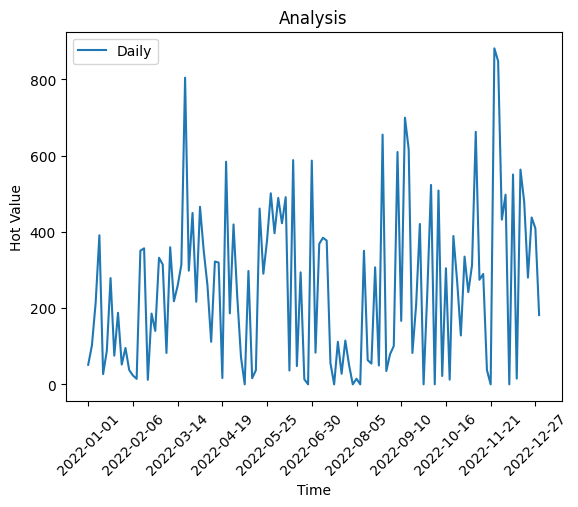

In [139]:
import matplotlib.pyplot as plt
# 创建一个新的图形
plt.figure()
topic_set_plt=['Society','Entertainment','Sport','Daily']


# 遍历每个列表并画折线
xticks = list(pd.date_range('2022-01-01', '2022-12-31', freq='36D').format(formatter=lambda x: x.strftime('%Y-%m-%d')))
plt.xticks([i*12 for i in range(11)], xticks, rotation=45)
show_topic = 3
day = [28, 64, 87]
# print(xticks[day // 2])
for i, line_data in enumerate(hot_data_trans):
    if i != show_topic:
        continue
    plt.plot(line_data, label=f'{topic_set_plt[i]}')
    # for j in day:
    #     plt.text(j, line_data[j], hot_represent_data_trans[show_topic][j], fontsize=12, color='red')    
    
# 添加标签和标题
plt.xlabel('Time')
plt.ylabel('Hot Value')
plt.title('Analysis')

# 添加图例
plt.legend()

# 显示图形
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

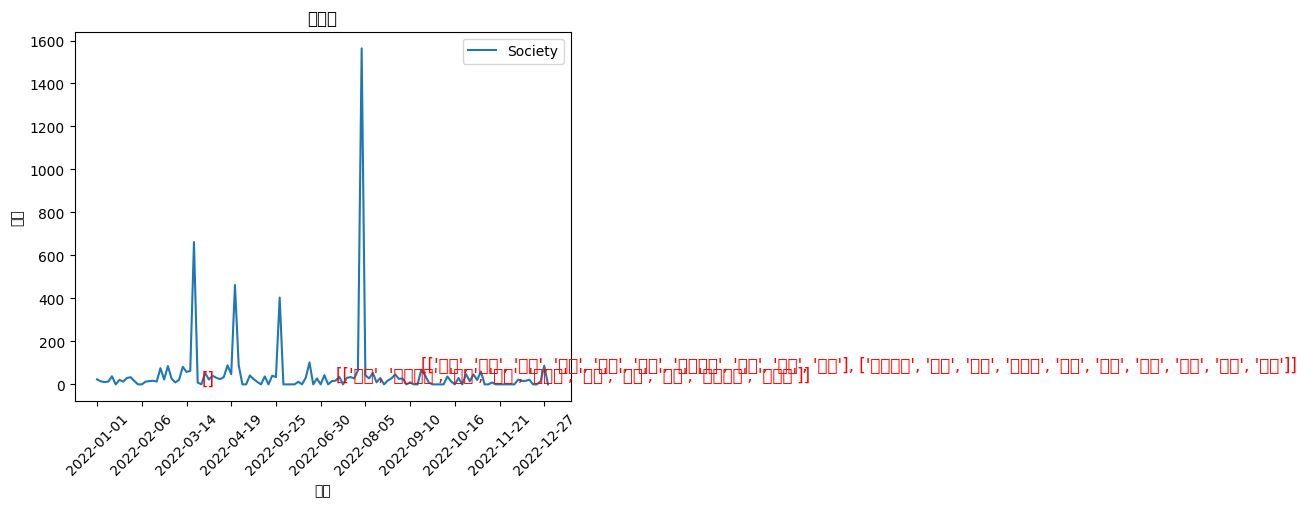

In [134]:
import matplotlib.pyplot as plt
import pandas as pd

# 强制 Matplotlib 使用中文字符集
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 创建一个新的图形
plt.figure()

topic_set_plt = ['Society', 'Entertainment', 'Sport', 'Daily', 'Health']

# 假设 hot_data_trans 和 hot_represent_data_trans 是你的数据
show_topic = 0
day = [28, 64, 87]
for i, line_data in enumerate(hot_data_trans):
    if i != show_topic:
        continue
    plt.plot(line_data, label=f'{topic_set_plt[i]}')
    for j in day:
        plt.text(j, line_data[j], hot_represent_data_trans[show_topic][j], fontsize=12, color='red')    

# 添加标签和标题
plt.xlabel('日期')
plt.ylabel('热度')
plt.title('热度图')

# 添加图例
plt.legend()

# 设置 x 轴刻度
xticks = list(pd.date_range('2022-01-01', '2022-12-31', freq='36D').format(formatter=lambda x: x.strftime('%Y-%m-%d')))
plt.xticks([i * 12 for i in range(11)], xticks, rotation=45)

# 显示图形
plt.show()


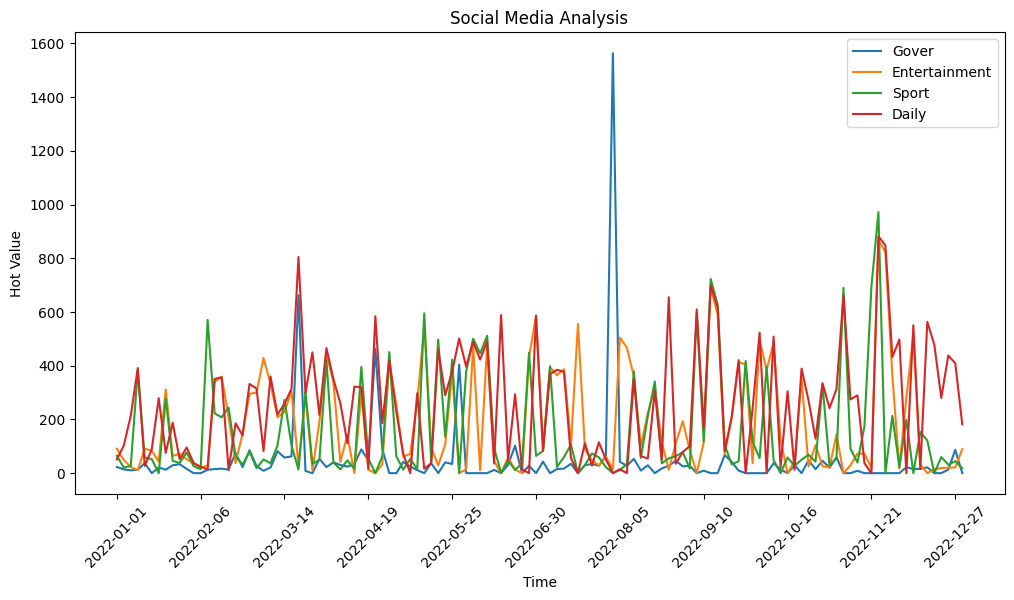

In [124]:
import matplotlib.pyplot as plt
# 创建一个新的图形
plt.figure(figsize=(12, 6))
topic_set_plt=['Gover','Entertainment','Sport','Daily']


# 遍历每个列表并画折线
for i, line_data in enumerate(hot_data_trans):
    plt.plot(line_data, label=f'{topic_set_plt[i]}')

xticks = list(pd.date_range('2022-01-01', '2022-12-31', freq='36D').format(formatter=lambda x: x.strftime('%Y-%m-%d')))
plt.xticks([i*12 for i in range(11)], xticks, rotation=45)

# 添加标签和标题
plt.xlabel('Time')
plt.ylabel('Hot Value')
plt.title('Social Media Analysis')

# 添加图例
plt.legend()

# 显示图形
plt.show()

In [19]:
from datetime import datetime, timedelta

# 设置开始日期和结束日期
start_date = datetime(2023, 1, 1)
end_date = datetime(2023, 12, 31)

# 设置步长为3天
step = timedelta(days=3)

# 生成日期序列
date_list = [start_date + i * step for i in range((end_date - start_date) // step + 1)]

# 将日期格式化为字符串
formatted_date_list = [date.strftime('%m月%d日') for date in date_list]

# 打印生成的日期列表
print(formatted_date_list)


['01月01日', '01月04日', '01月07日', '01月10日', '01月13日', '01月16日', '01月19日', '01月22日', '01月25日', '01月28日', '01月31日', '02月03日', '02月06日', '02月09日', '02月12日', '02月15日', '02月18日', '02月21日', '02月24日', '02月27日', '03月02日', '03月05日', '03月08日', '03月11日', '03月14日', '03月17日', '03月20日', '03月23日', '03月26日', '03月29日', '04月01日', '04月04日', '04月07日', '04月10日', '04月13日', '04月16日', '04月19日', '04月22日', '04月25日', '04月28日', '05月01日', '05月04日', '05月07日', '05月10日', '05月13日', '05月16日', '05月19日', '05月22日', '05月25日', '05月28日', '05月31日', '06月03日', '06月06日', '06月09日', '06月12日', '06月15日', '06月18日', '06月21日', '06月24日', '06月27日', '06月30日', '07月03日', '07月06日', '07月09日', '07月12日', '07月15日', '07月18日', '07月21日', '07月24日', '07月27日', '07月30日', '08月02日', '08月05日', '08月08日', '08月11日', '08月14日', '08月17日', '08月20日', '08月23日', '08月26日', '08月29日', '09月01日', '09月04日', '09月07日', '09月10日', '09月13日', '09月16日', '09月19日', '09月22日', '09月25日', '09月28日', '10月01日', '10月04日', '10月07日', '10月10日', '10月13日', '10月16日', '10月19日', '10月22日', '10月25日',

In [20]:
topic_number = 0
day_part = 
hot_data_trans_part=hot_data_trans[topic_number]
hot_content_trans_part=hot_content_data_trans[topic_number]

label_data=[]
for i in range(len(hot_data_trans)):
    if(hot_data_trans[i]>1000):
        label_data.append(hot_content_data_trans[i])
    else:
        label_data.append(' ')

for x, y in zip(x_axis_data, hot_data_trans_part):
    plt.text(x, y+0.3, '%.00f' % y, ha='center', va='bottom', fontsize=7.5)#y_axis_data1加标签数据
    
plt.plot(x_axis_data, hot_data_trans_part, 'b*--', alpha=0.5, linewidth=1, label='acc')#'bo-'表示蓝色实线，数据点实心原点标注
## plot中参数的含义分别是横轴值，纵轴值，线的形状（'s'方块,'o'实心圆点，'*'五角星   ...，颜色，透明度,线的宽度和标签 ，

plt.legend()  #显示上面的label
plt.xlabel('time') #x_label
plt.ylabel('number')#y_label
 
#plt.ylim(-1,1)#仅设置y轴坐标范围
plt.show()


SyntaxError: invalid syntax (2670275851.py, line 2)

In [30]:
baseline=[]
baseline.append(hot_content_data_trans)
baseline.append(hot_data_trans)
baseline.append(hot_represent_data_trans)
import numpy as np
bs_local=np.asarray(baseline,dtype=object)
np.save('baseline_4.npy',bs_local) # 保存为.npy格式
# loaded_array = np.load('baseline.npy', allow_pickle=True)

# # 将数组转换为普通的 Python 列表
loaded_list = loaded_array.tolist()
hot_data_trans_new=loaded_list[1]


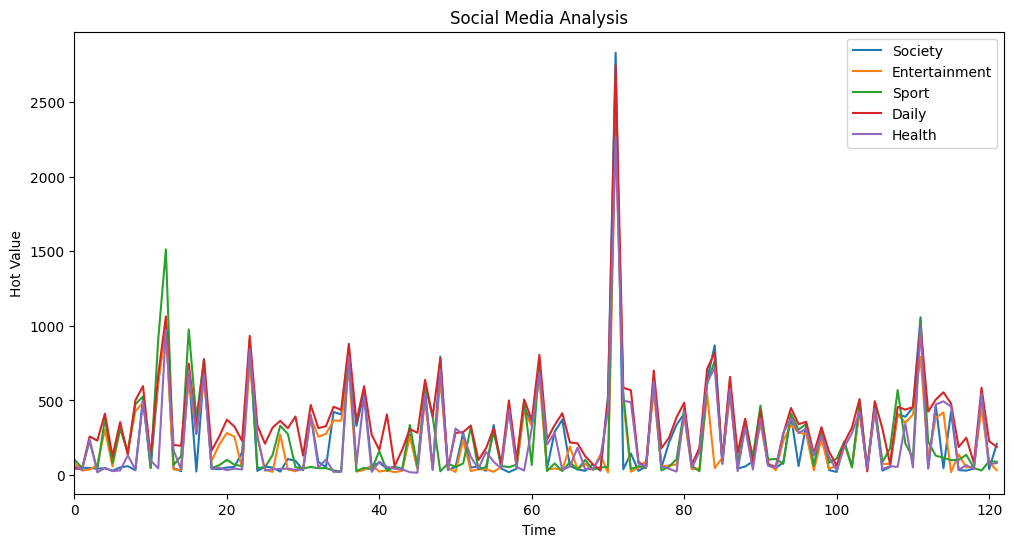

In [ ]:
import matplotlib.pyplot as plt
# 创建一个新的图形

plt.figure(figsize=(12, 6))
topic_set_plt=['Society','Entertainment','Sport','Daily','Health']


# 遍历每个列表并画折线
for i, line_data in enumerate(hot_data_trans_new):
    plt.plot(line_data, label=f'{topic_set_plt[i]}')

# 添加标签和标题
plt.xlabel('Time')
plt.ylabel('Hot Value')
plt.title('Social Media Analysis')

# 添加图例
plt.legend()
plt.xlim(0, len(hot_data_trans_new[0]))

# 显示图形
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_axis_data = [1,2,3,4,5,6,7] #x
y_axis_data = [68,69,79,71,80,70,66] #y

for x, y in zip(x_axis_data, y_axis_data):
    plt.text(x, y+0.3, '%.00f' % y, ha='center', va='bottom', fontsize=7.5)#y_axis_data1加标签数据
    
plt.plot(x_axis_data, y_axis_data, 'b*--', alpha=0.5, linewidth=1, label='acc')#'bo-'表示蓝色实线，数据点实心原点标注
## plot中参数的含义分别是横轴值，纵轴值，线的形状（'s'方块,'o'实心圆点，'*'五角星   ...，颜色，透明度,线的宽度和标签 ，

plt.legend()  #显示上面的label
plt.xlabel('time') #x_label
plt.ylabel('number')#y_label
 
#plt.ylim(-1,1)#仅设置y轴坐标范围
plt.show()


In [ ]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,223,-1_共享_口罩_奥密克戎_无法,"[共享, 口罩, 奥密克戎, 无法, 阻止, 普通外科, 回来, 臭豆腐, 发黄, 成小]","[普通外科 口罩 无法 阻止 奥密克戎, 普通外科 口罩 无法 阻止 奥密克戎, 普通外科 ..."
1,0,927,0_跨年_新冠_中国_刘鑫,"[跨年, 新冠, 中国, 刘鑫, 专家, 感冒, 阳后, 卫视, 女子, 江歌]","[美 专家 称 中国 出现 危险 变异 株 可能性 极低, 美 专家 称 中国 出现 危险 ..."
2,1,171,1_2022_2023_新年贺词_视频,"[2022, 2023, 新年贺词, 视频, 完整, 最后, 美好, 告别, 厕所, 领导]","[2023 新年贺词 完整 视频, 2023 新年贺词 完整 视频, 2023 新年贺词 完..."
3,2,38,2_坚忍不拔_努力_爹妈_英语专业,"[坚忍不拔, 努力, 爹妈, 英语专业, 体验, 感谢, 别忘记, 勇敢, , ]","[坚忍不拔 努力, 坚忍不拔 努力, 坚忍不拔 努力]"
4,3,30,3_美军_真相_机抵_揭露,"[美军, 真相, 机抵, 揭露, 战区, 南部, 侦察, 拦截, 解放军, 侦察机]","[南部 战区 揭露 美军 机抵 近 侦察 真相, 南部 战区 揭露 美军 机抵 近 侦察 真..."
5,4,29,4_祝愿_新年快乐_所愿_,"[祝愿, 新年快乐, 所愿, , , , , , , ]","[祝愿 新年快乐 皆 所愿, 祝愿 新年快乐 皆 所愿, 祝愿 新年快乐 皆 所愿]"
6,5,24,5_男篮_辽宁_浙江_vs,"[男篮, 辽宁, 浙江, vs, 战胜, 广东, 北京, , , ]","[浙江 男篮 vs 辽宁 男篮, 浙江 男篮 vs 辽宁 男篮, 浙江 男篮 vs 辽宁 男篮]"
7,6,21,6_造型_公主_鎏金_虞书欣,"[造型, 公主, 鎏金, 虞书欣, 金色, 八冠, estar, 毛衣, 长裙, 路透]","[虞书欣 鎏金 紫 公主 裙 造型, 虞书欣 鎏金 紫 公主 裙 造型, 虞书欣 鎏金 紫 ..."
8,7,21,7_职业规划_失败_面试_hr,"[职业规划, 失败, 面试, hr, 女子, 薪资, 疑似, 海外, 拖欠, 员工]","[女子 面试 失败 遇 HR 帮 职业规划, 女子 面试 失败 遇 HR 帮 职业规划, 女..."
9,8,20,8_需要_阳康后_口罩_,"[需要, 阳康后, 口罩, , , , , , , ]","[阳康后 需要 戴 口罩, 阳康后 需要 戴 口罩, 阳康后 需要 戴 口罩]"


In [ ]:
# 可视化选定的主题和文档
# topic_model.visualize_documents(docs)


In [ ]:
new_topics = topic_model.reduce_outliers(docs, topics)
topic_model.update_topics(docs, topics=new_topics)


100%|██████████| 1/1 [00:00<00:00, 35.24it/s]
2023-12-24 22:28:39,614 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
# topic_model.get_topic_info()


In [ ]:
flg = topic_model.visualize_documents(docs)
flg.write_image('output.png')
